In [1]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from tqdm import tqdm
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels

from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
)

from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter

In [2]:
# Seed for reproducibility
# np.random.seed(42)

t, prices, vol_sto = StochasticModels.simulate_heston_process_with_jump(5, 100)

df = pd.DataFrame({"t": t, "prices": prices, "vol_sto": vol_sto})
df["returns"] = df.prices.pct_change().fillna(0)
df["vol"] = df.returns.rolling(30).std().apply(lambda x: x * np.sqrt(252))
df = df.dropna().reset_index(drop=True)
df

,t,prices,vol_sto,returns,vol
0,0.115079,82.517349,0.301876,-0.063009,0.729832
1,0.119048,77.232199,0.267866,-0.064049,0.749149
2,0.123016,72.973497,0.256299,-0.055142,0.761279
3,0.126984,74.968245,0.200110,0.027335,0.766747
4,0.130952,76.247450,0.183668,0.017063,0.769392
...,...,...,...,...,...
1227,4.984127,36.997254,0.770877,-0.082844,0.948231
1228,4.988095,34.028370,0.801390,-0.080246,0.983033
1229,4.992063,33.535356,0.784327,-0.014488,0.980563
1230,4.996032,32.855249,0.719258,-0.020280,0.981420


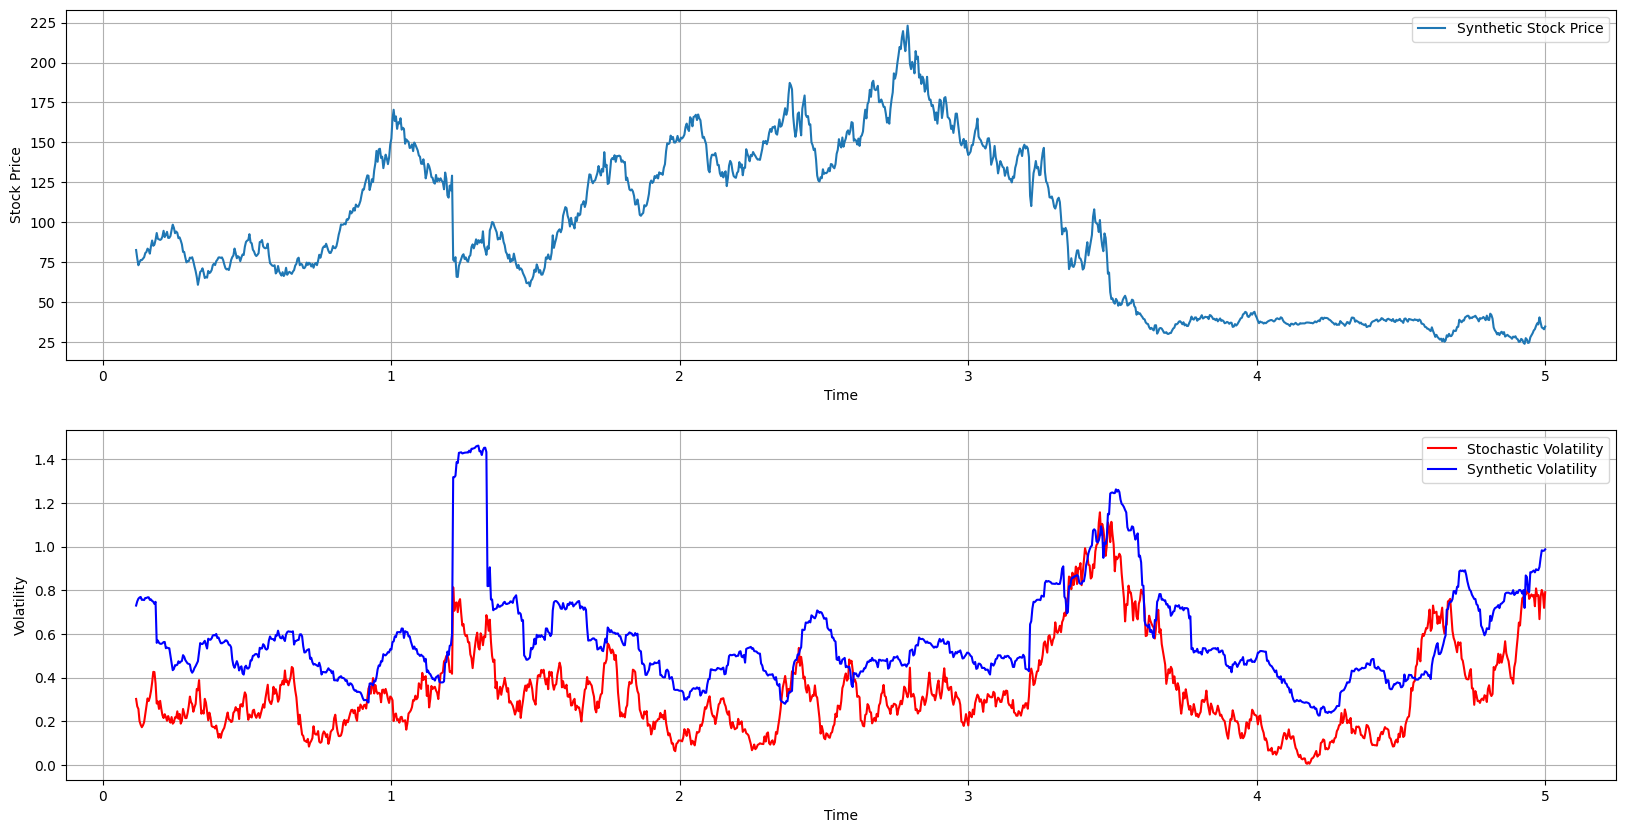

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.t, df.prices, label="Synthetic Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.t, df.vol_sto, color="red", label="Stochastic Volatility")
ax[1].plot(df.t, df.vol, color="blue", label="Synthetic Volatility")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [4]:
# dff = pd.read_excel('../data/Appl_data.xlsx',)[["Date","price",'nb tick']] #sheet_name="Feuil3"
# dff = dff.rename(columns={"Date": "t", "price": "prices"})
# dff['returns'] = dff.prices.pct_change().fillna(0)
# dff['vol'] = dff.returns.rolling(30).std()
# dff['volvol'] = dff.vol.rolling(30).std()

# fig, ax = plt.subplots(3, 1, figsize=(20, 10))

# ax[0].plot(dff.prices, label="Stock Price")
# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Stock Price")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(dff.vol, color="blue", label="Volatility")
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Volatility")
# ax[1].legend()
# ax[1].grid()
# ax[2].plot(dff.volvol, color="blue", label="Volatility of Volatility")
# ax[2].set_xlabel("Time")
# ax[2].set_ylabel("Volatility of Volatility")
# ax[2].legend()
# ax[2].grid()

## SImple example


UKF: 100%|██████████| 1231/1231 [00:00<00:00, 1780.43it/s]


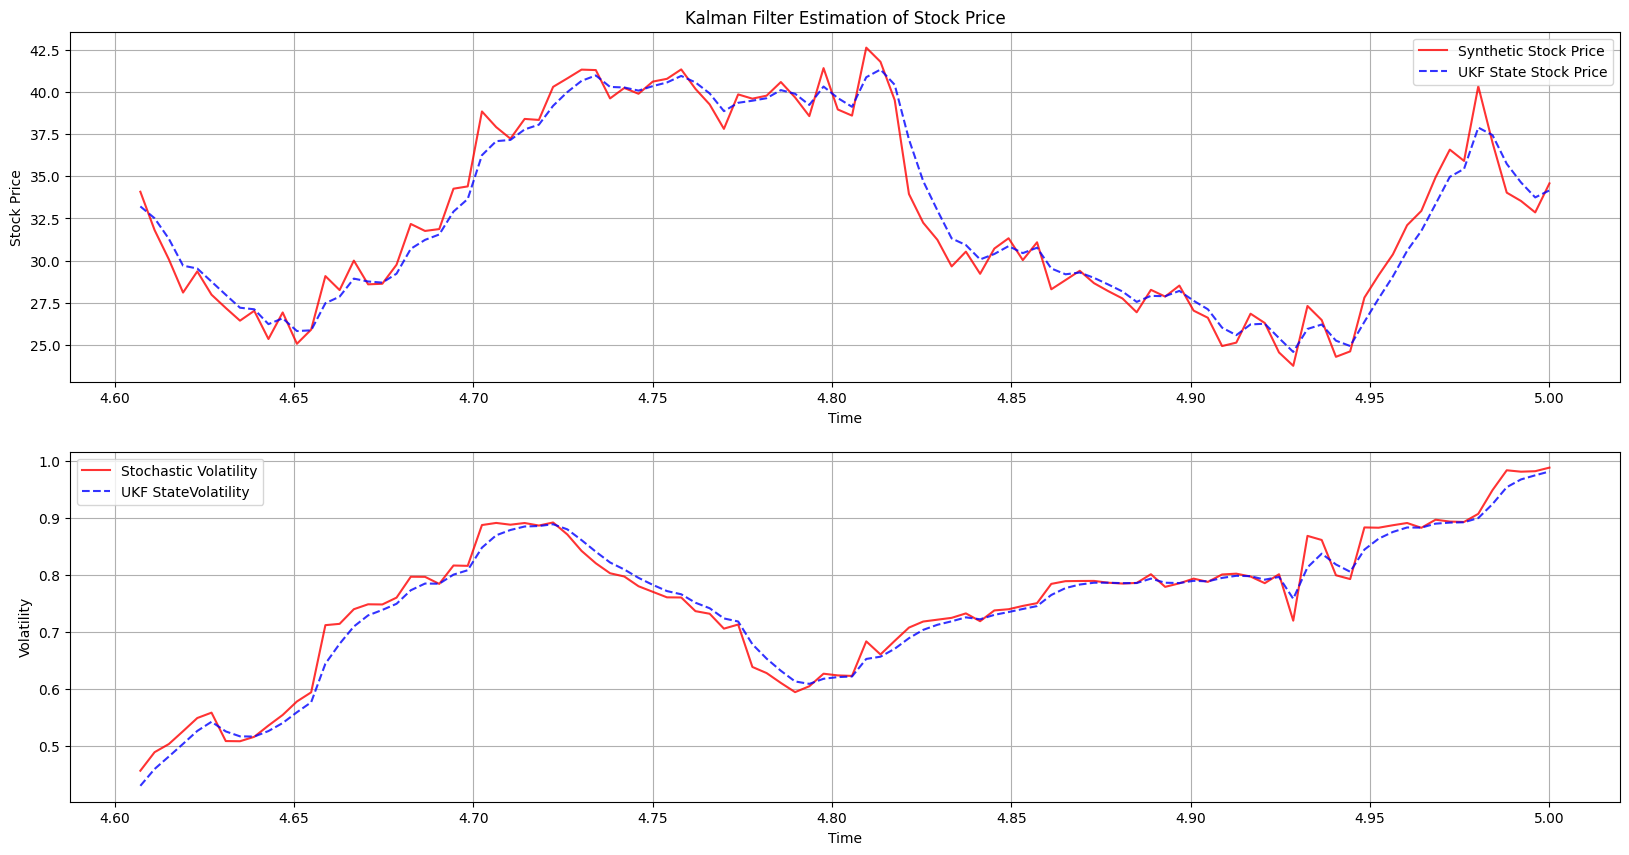

In [18]:
Z = df[["prices", "vol"]].to_numpy()

ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 10]]),
    R=np.array([[5, 0.0], [0.0, 10]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, z=Z, x0=Z[0])

N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)
ax[1].plot(
    df.t[-N:],
    X_hat[-N:, -1],
    color="blue",
    label="UKF StateVolatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

## Our SSM


In [6]:
from typing import List
from filters.ssm import DSSM

# order [kappa, theta, xi, rho, mu, p, ]
LEARNABLE_PARAMS = [4, 0.27, 0.99, -0.3, 0.3, 0.5]

dssm = DSSM(LEARNABLE_PARAMS)

In [7]:
df["prices_t_1"] = df.prices.shift(1)
Z = df[["vol","prices", "prices_t_1"]].dropna().to_numpy()


In [12]:
ukf = UnscentedKalmanFilter(
    dim_x=3,
    dim_z=3,
    Q=np.array([[10, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]),
    R=np.array([[5, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]),

)

X_hat, _, X_hat_estim = ukf.fit_predict(
    dssm.f,
    dssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["vol","prices", "prices_t_1"]].dropna().to_numpy()[0],
    verbose=False,
    keep_state_estimates=True,
)


UKF:   0%|          | 0/1230 [00:00<?, ?it/s]

UKF: 100%|██████████| 1230/1230 [00:01<00:00, 1093.09it/s]


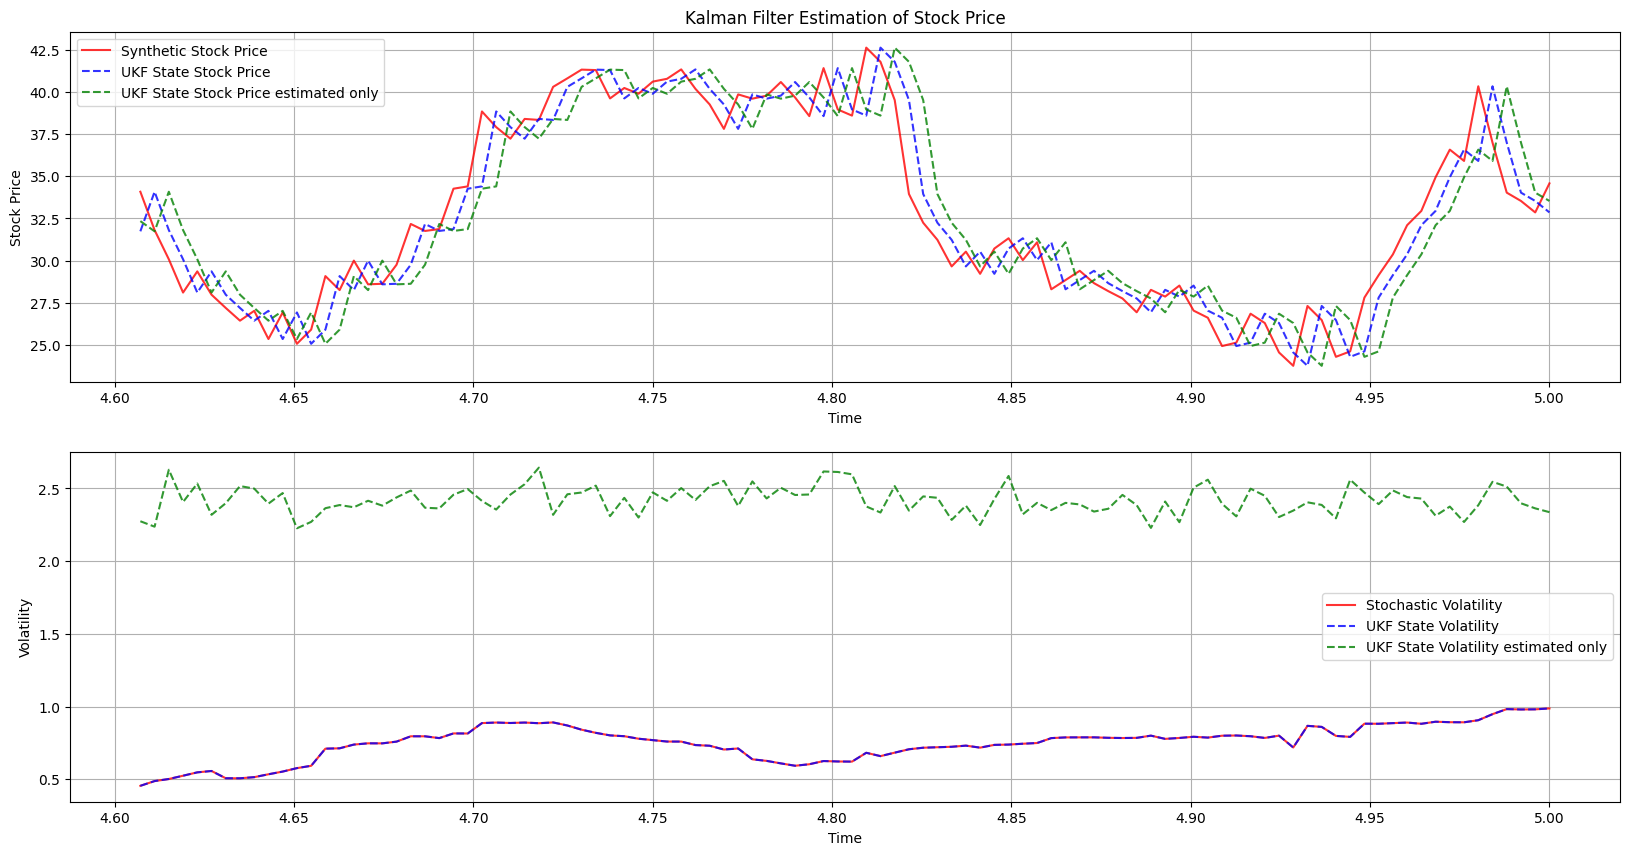

In [17]:
N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].plot(
    df.t[-N:],
    X_hat_estim[-N:, 1],
    color="green",
    label="UKF State Stock Price estimated only",
    alpha=0.8,
    linestyle="--",
)

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)

ax[1].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Volatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].plot(
    df.t[-N:],
    X_hat_estim[-N:, 0],
    color="green",
    label="UKF State Volatility estimated only",
    alpha=0.8,
    linestyle="--",
)


ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [10]:
# ukf = UnscentedKalmanFilter(
#     dim_x=3,
#     dim_z=1,
#     Q=np.array([[5, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
#     R=np.array([[5]]),
# )

# X_hat, _ = ukf.fit_predict(
#     dssm.f,
#     dssm.h,
#     z=Z,
#     u=np.stack(
#         StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
#     ),
#     x0=df[["vol","prices", "prices_t_1"]].dropna().to_numpy()[0],
# )
# # print(x, K, z, y)
# # x = x + (K @ (z - y))

In [11]:
# Z = df[["prices", "vol"]].to_numpy()

# ukf = UnscentedKalmanFilter(
#     dim_x=Z.shape[-1],
#     dim_z=Z.shape[-1],
#     Q=np.array([[5, 0.0], [0.0, 10]]),
#     R=np.array([[5, 0.0], [0.0, 10]]),
# )


# def f(x, u, v):
#     return x + u + v


# def h(x, u, n):
#     return x + u + n


# X_hat, _ = ukf.fit_predict(f, h, z=Z)